# Deep Learning Essentials: A Comprehensive PyTorch Tutorial

Halfway through [CS231n](http://cs231n.stanford.edu/) lectures and assignments, I decided to write this tutorial on **PyTorch** and **the best neural network practices** by implementing an image classification project. Despite the problem being simple, it is a great starting point as many other Computer Vision problems like object detection and segmentation are based on image classification. This tutorial is heavily inspired by the teachings of [Andrej Karpathy](https://karpathy.ai/). It covers the most basic and essential information you should definitely know if you’re getting started with your ML/DL career.

To run this notebook locally:
1. Download the CIFAR-10 dataset from [here](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz) 
2. Create a `dataset` folder in the same directory as the notebook and extract it there 

With Kaggle:
1. Import notebook into Kaggle (gives free 32 GPU hours once verified)
2. Search for [CIFAR-10](https://www.kaggle.com/datasets/pankrzysiu/cifar10-python) dataset and add it
3. Enable GPU and you're good to go 

Model weights are available [here](https://drive.google.com/drive/folders/1-3Fx7Z-DT-59eIS2YGHADRWf19p5JadK)

## 1. Why do we use neural nets? 
If you were asked to write a function to take an image and tell if it is a cat or a dog, where would you start? It is not as straightforward as writing an algorithm for reversing a linked list, for example. You might attempt to write code that detects sharp or pointy structures to infer the presence of a cat. However, as you delve deeper, handling challenges like viewpoint variation, deformation, illumination conditions, background clutter, etc., becomes increasingly daunting. And what if we now have to identify human beings? for example. We would be back to square one. Hence, **the data-driven approach**. Instead of explicitly writing code to solve a problem, we let the neural net figure out a mapping by showing a large number of data inputs and labels.

## 2. The bigger picture: What does it mean to train a neural network?
In simple terms all you're doing is **_finding the best set of weights._** Your neural net is like a mathematical function, albeit a complex one, with a lot of numbers to learn the mapping between inputs and outputs. We learn these numbers a.k.a weights using a data-driven approach. We just start with random numbers and iteratively update them with the following steps:
1. **Data sampling**: Sample a batch of data: `(x, y)`
2. **Forward propagation**: Make a prediction: `preds = forward(x)`
3. **Loss computation**: Quantify how wrong the predictions are: `loss(preds, y)`
4. **Backward propagation**: Calculate the gradients: `dw = loss.backward()`
5. **Weight update**: Adjust weights to minimize loss: `w -= lr * dw`

Note: Gradients point towards the steepest ascent on the loss surface, and our objective is to move in the opposite direction for loss minimization.

## 3. The most important thing to remember: **_Simplify_**
There's lot of fancy stuff you may be tempted to use when working with neural nets. Should you do data augmentation, learning rate scheduling, regularization, etc., all at once when you start? **No.** Each one is an opportunity to introduce a bug. Keep it simple. Incorporate them in stages to stay sane.

Code one small function at a time. Verify it's doing what it's supposed to do. Incrementally add complexity. We will be performing sanity checks each time we build something.

## 4. PyTorch autograd engine

The main power of PyTorch comes from its autograd engine. If you were a deep learning researcher in early 2010s, you had to implement forward prop, backward prop for activations, conv layers, etc., all by yourself. With PyTorch, you only have to figure out the forward function for your model using the APIs from the neural network package: `torch.nn`. It will then perform backpropagation for you. If any `torch` variable has its `requires_grad` attribute set to `True`, PyTorch will create a dynamic computational graph and store all the operations performed on it.  All you have to do is call `.backward()` on the output and it will accumulate gradients for the intermediate variables in the `.grad` attributes. Let's look at a concrete example: **the Sigmoid activation**.<br>

### Without PyTorch (or other DL libraries)

Need to write both `forward()` and `backward()`.

In [1]:
import numpy as np
np.random.seed(17)

class Sigmoid:
    """
    Implements the forward and backward APIs for a layer of Sigmoid units.
    """
    def __init__(self, x):
        self.x = x
        self.cache = None

    def forward(self):
        out = 1 / (1 + np.exp(-self.x))
        self.cache = out
        return out

    def backward(self, dout):
        sigmoid = self.cache
        dx = (sigmoid * (1 - sigmoid)) * dout
        return dx

x = np.random.randn(4, 5)
dout = np.ones((4, 5)) # upstream derivative

sigmoid = Sigmoid(x)
out = sigmoid.forward()
dx = sigmoid.backward(dout)
print(dx)

[[0.24528985 0.1170161  0.2271672  0.18309839 0.19320952]
 [0.1143022  0.24922184 0.24198097 0.24862356 0.2383941 ]
 [0.09188361 0.18243502 0.12009486 0.24881267 0.23263532]
 [0.12389451 0.16686695 0.23649767 0.18809787 0.24613324]]


### With PyTorch

You only have to write code for forward prop: `out = 1 / (1 + torch.exp(-x))`. Backprop is as easy as calling `out.backward()`. <br>

In [4]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(17)

y = torch.tensor(np.copy(x), requires_grad=True)
dout = torch.ones((4, 5))

out = 1 / (1 + torch.exp(-y))
out.backward(dout)
print(y.grad)

tensor([[0.2453, 0.1170, 0.2272, 0.1831, 0.1932],
        [0.1143, 0.2492, 0.2420, 0.2486, 0.2384],
        [0.0919, 0.1824, 0.1201, 0.2488, 0.2326],
        [0.1239, 0.1669, 0.2365, 0.1881, 0.2461]], dtype=torch.float64)


The gradients are consistent in both implementations. While this is only a small taste, you can implement a forward function that is significantly complex. For example, Implementing an architecture like the Inception Net where auxiliary classifiers branch out of the main stem of the network, or Resnet which has skip connections, would still be relatively easy with PyTorch. Checkout how to implement the Inception Net architecture [here.](https://github.com/Vinaypnaidu/InceptionNet-pytorch) <br>

## 5. Understanding the data

The [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class.

Each data batch (dictionary) contains:
1. data: a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue.
2. labels: a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.

In [6]:
# from the CIFAR-10 website
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# change this path if you're working with kaggle
DATASET_PATH = './dataset/cifar-10-batches-py'

meta = unpickle(DATASET_PATH + '/batches.meta')
class_names = {}
for i, ex in enumerate(meta[b'label_names']):
    class_names[i] = ex.decode('utf-8')

print("CIFAR-10 classes:")
print(class_names, '\n')

print("Data batch keys:")
data_batch1 = unpickle(DATASET_PATH + '/data_batch_1')
print(data_batch1.keys())
print("Data dimensions:", data_batch1[b'data'].shape)
print("Labels' dimensions:", len(data_batch1[b'labels']))

CIFAR-10 classes:
{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'} 

Data batch keys:
dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
Data dimensions: (10000, 3072)
Labels' dimensions: 10000


Class: dog 



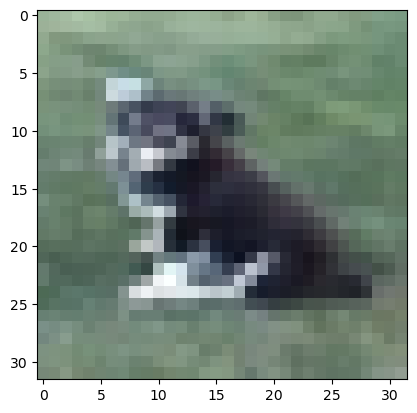

In [7]:
from matplotlib.pyplot import imshow

# image with index 70
idx = 70
img = np.reshape(data_batch1[b'data'][idx], (3, 32, 32)) # reshape to (C, H, W)
imshow(img.transpose(1, 2, 0)) # convert to (H, W, C)
print("Class:", class_names[data_batch1[b'labels'][idx]], '\n')

It is a good idea to spend enough time going through the dataset to gain some intuitions and recognize patterns in the dataset. You should also filter your dataset if you find any corrupt images or labels, especially if you build one from scratch.  <br>

## 6. Set up the end-to-end training/evaluation pipeline
### 6.1 Writing a custom `Dataset` class
In order to train, we need to iterate through the dataset and fetch a minibatch of data each time we run forward and backward prop. This is done by the DataLoader. PyTorch provides two data primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset` that allow you to use pre-loaded datasets as well as your own data. `Dataset` stores the samples and their corresponding labels, and `DataLoader` wraps an iterable around the `Dataset` to enable easy access to the samples. <br>

Let's use the knowledge gained from exploring the dataset to create a Dataset class. It should implement the following methods: <br>

1. `__init__`: Responsible for initializing the attributes that we might need, root represents the path of the dataset, train argument tells if it is a train split or not and the transform attribute is used to perform data augmentation using transformations like RandomRotation, ColorJitter and RandomHorizontalFlip. We also extract the training and testing data depending on the split, reshape them and store them in `self.images` and `self.labels`.

2. `__len__`: Returns the length of the training set.

3. `__getitem__`: Fetches one sample from the dataset based on a given index. It will be used by the Dataloader for fetching a batch of samples. Data augmentation and normalization are also done in this step.

In [8]:
import os
import pickle
from PIL import Image
from torch.utils.data import Dataset

class CIFAR10(Dataset):
    def __init__(self, root, train=True, transform=None, target_transform=None):
        self.root = root
        self.train = train
        self.transform = transform
        self.target_transform = target_transform
        self.load_meta()

        batches = []
        labels = []
        for batch in ['data_batch_1', 'data_batch_2', 'data_batch_3',
                      'data_batch_5', 'data_batch_4', 'test_batch']:
            if self.train:
                if batch.startswith("data"):
                    unpickled = self.unpickle(os.path.join(root, batch))
                    batches.append(unpickled[b'data'])
                    labels.extend(unpickled[b'labels'])
            else:
                if batch.startswith("test"):
                    unpickled = self.unpickle(os.path.join(root, batch))
                    batches.append(unpickled[b'data'])
                    labels.extend(unpickled[b'labels'])

        # stack all batches and reshape to (C, H, W)
        stacked = np.vstack(np.array(batches)).reshape(-1, 3, 32, 32)
        # convert to PIL format (H, W, C) to use ToTensor()
        self.images = np.transpose(stacked, (0, 2, 3, 1))
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Convert numpy array to PIL Image
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

    def unpickle(self, file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict

    # get class names
    def load_meta(self):
        metadata = os.path.join(self.root, 'batches.meta')
        meta = unpickle(metadata)
        class_names = {}
        for i, ex in enumerate(meta[b'label_names']):
            class_names[i] = ex.decode('utf-8')
        self.class_names = class_names


### 6.2 `DataLoader` and train-test-val splits

We can apply a series of transforms using the `torchvision.transforms.Compose` class. In the following transform, if enabled, data augmentation is done randomly with a probability of 0.5. `ToTensor()` rescales the data to range (0, 1) and shape (C, H, W). `Normalize()` then normalizes the data using per channel means and standard devations.

Note: We avoid data augmentation at this stage `augment=False`, we will incorporate it later as a regularization strategy.

In [10]:
import torchvision.transforms as T

def return_transform(augment=False):
    if augment:
        return T.Compose([
            T.RandomApply([
                T.RandomRotation(10),
                T.RandomResizedCrop(32, scale=(0.8, 1.0)),
                T.ColorJitter(brightness=0.2, contrast=0.2,
                              saturation=0.2, hue=0.1)
            ], p=0.5),
            T.ToTensor(),
            T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
        ])
    else:
        return T.Compose([
            T.ToTensor(),
            T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
        ])

DATASET_PATH = './dataset/cifar-10-batches-py'

cifar10_train = CIFAR10(
    root=DATASET_PATH,
    train=True,
    transform=return_transform(augment=False)
)

cifar10_test = CIFAR10(
    root=DATASET_PATH,
    train=False,
    transform=return_transform(augment=False)
)

While we already have the dataset divided into train and test sets, we still need a validation set. Hence we divide the train set further to have a train split with 49000 examples and a val split with 1000 examples. This is done using a sampler: `torch.utils.data.SubsetRandomSampler`. However, since our validation set is a proxy for test set, we need to make sure that all the classes are equally covered. This is done using `StratifiedShuffleSplit` from scikit-learn. For classification tasks, this step is particularly important.

In [11]:
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data.sampler import SubsetRandomSampler

NUM_TRAIN = 49000
BATCH_SIZE = 64

# Divide cifar10_train to train and val using stratified split
labels = cifar10_train.labels
split = StratifiedShuffleSplit(n_splits=1, test_size=50000-NUM_TRAIN, random_state=17)
train_indices, val_indices = next(split.split(range(len(cifar10_train)), labels))

loader_train = DataLoader(
    cifar10_train,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    sampler=SubsetRandomSampler(train_indices))

loader_val = DataLoader(
    cifar10_train,
    batch_size=BATCH_SIZE,
    sampler=SubsetRandomSampler(val_indices))

loader_test = DataLoader(cifar10_test, batch_size=BATCH_SIZE)

### Sanity check: Visualizing batch data
Visualizing what goes into your model is one of the most important tasks. It will help you avoid a lot of headaches that may come later. The model may not be seeing what you think it is, and its best to ensure that such disparities do not exist. <br>

We first check **without unnormalizing** to see exactly what the model is seeing. The patterns in the images should look roughly similar to the original data. If at this stage you see something that looks corrupted it may be worthwhile to recheck your implementation. It is also recommended to visualize just before we call forward prop: `model(x)`. <br>

Note: Be extra careful about shapes as some functions expect image data in `(H, W, C)` while some want it in `(C, H, W)` format.

In [12]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def visualize_batch(minibatch, unnormalize=False, class_names=None, save=False, batch=0):
    # create grid using make_grid
    inputs, classes = minibatch
    ncols = int(np.sqrt(inputs.shape[0]))
    nrows = int(np.ceil(inputs.shape[0] / ncols))
    img = make_grid(inputs, nrow=ncols) # (C, H, W)

    plt.figure(figsize=(7, 7))
    img = img.numpy().transpose((1, 2, 0)) # change to (H, W, C)
    if unnormalize:
        mean = np.array([0.4914, 0.4822, 0.4465])
        std = np.array([0.2023, 0.1994, 0.2010])
        img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.axis('off')
    plt.imshow(img)

    # visualize along with labels
    img_width = img.shape[1] / ncols
    img_height = img.shape[0] / nrows
    for idx, label in enumerate(classes):
        row = idx // ncols
        col = idx % ncols
        x = col * img_width
        y = (row + 1) * img_height
        plt.text(x, y, class_names[label.item()], color='white', fontsize=7,
                 bbox=dict(facecolor='black', alpha=0.5))

    if save:
        plt.savefig(f'./logs/trainbatch{batch}.jpg')
        plt.close()

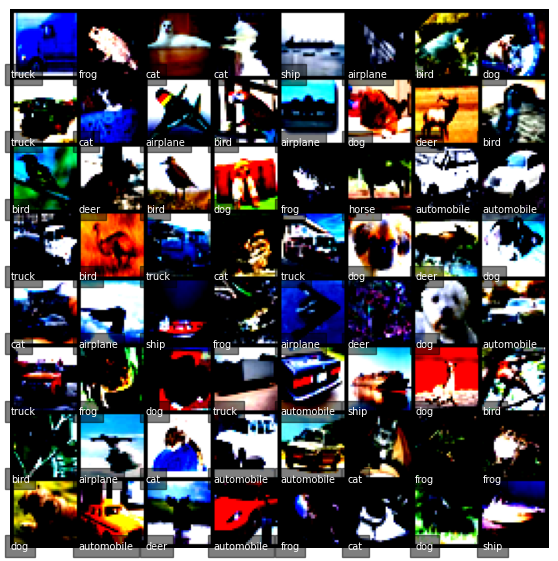

In [13]:
minibatch = next(iter(loader_train))
visualize_batch(minibatch, unnormalize=False, class_names=cifar10_train.class_names)

We also check the **unnormalized version**, which should look more closer to our original dataset.

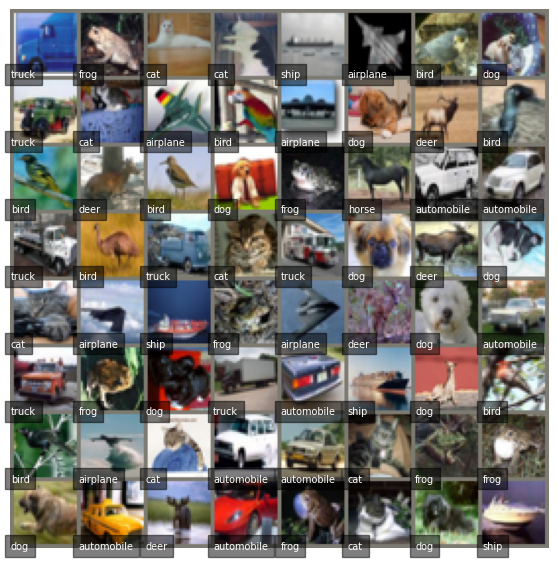

In [14]:
visualize_batch(minibatch, unnormalize=True, class_names=cifar10_train.class_names)

### 6.3 Building the neural network model
We implement a small 10 layer neural network because of limited compute, but you can opt for larger and more powerful architectures depending on your hardware capabilities. <br>

Whenever you take up a problem, it is often advisable to start with established architectures and customize only the final layers to suit your dataset and the problem. For instance, if your task involves identifying keypoints on objects, consider adapting the [YOLOv7-pose](https://github.com/WongKinYiu/yolov7/tree/pose) architecture instead of building a keypoint model from scratch.

The `ConvNet` class, subclasses the neural network module: `nn.Module` provided by PyTorch, It is a very powerful and flexible API to build neural network architectures. Our `ConvNet` class needs to implement two key methods:

1. `__init__`: Initializes the layers within the neural network, including convolutional layers, pooling layers, and other operations.

2. `forward`: Defines the forward propagation of the network.

Architectural details:
1. Kernel Size: We will use a `3x3` kernel size for all convolutional layers, for simplicity.
2. Same Padding: Padding will be applied such that spatial dimensions `32x32` are maintained.
3. Weight Initialization: By default, PyTorch uses Kaiming initialization for `nn.Conv2d`, which is recommended for ReLU units.
4. Batch Normalization: To enhance convergence, we'll incorporate `nn.BatchNorm2d` layers.

Note: The order in which we perform these operations are: **conv followed by batchnorm followed by activation**: `F.relu(self.bn(self.conv(x)))`

In [15]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.conv9 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        self.fc10 = nn.Linear(32*32*16, 10)

        # add batchnorm layers
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm2d(256)
        self.bn6 = nn.BatchNorm2d(128)
        self.bn7 = nn.BatchNorm2d(64)
        self.bn8 = nn.BatchNorm2d(32)
        self.bn9 = nn.BatchNorm2d(16)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))
        x = F.relu(self.bn9(self.conv9(x)))
        # need to flatten the tensor before nn.Linear
        scores = self.fc10(x.reshape(x.shape[0], -1))
        return scores

To verify output shape, and as a sanity check, we run our model on a mini-batch of zeros.

In [16]:
x = torch.zeros((64, 3, 32, 32))
model = ConvNet()
scores = model(x)
print(scores.shape) # should see [64, 10]

torch.Size([64, 10])


### Sanity check: Verify loss at init
It is often recommended to verify the loss before training by deriving it. For image classification, we use Cross-entropy loss, which is defined as:<br>
<br>
$$L(y, z) = -\log\left(\frac{e^{z_y}}{\sum_{j} e^{z_j}}\right)$$
Where:
- $z$ represents class scores (logits)
- $y$ is the index of the correct class
- $j$ is the index of a class
<br>

Given that we've initialized our model weights with small random numbers close to zero (Kaiming init), the scores variable: **$z$ will also have values roughly close to 0**. This reduces our loss to `-log(1/num_classes)`,  which should be around **2.3** since we have 10 classes.

In [17]:
x, y = minibatch
model = ConvNet()
model.eval()
scores = model(x)
loss = F.cross_entropy(scores, y)
print(loss.item())

2.303802013397217


### 6.4 Building the training loop

The core of every training loop performs the following operations, Hence it's advised that you build this part first.
1. **Data sampling**: Sample a batch of data: `(x, y)`
2. **Forward propagation**: `scores = model(x)`
3. **Loss computation**: `F.cross_entropy(scores, y)` (for classification)
4. **Backward propagation**:
     1. `optimizer.zero_grad()`: set the gradients of all weights to zero
     2. `loss.backward()`: calculate the gradients for all weights
5. **Weight update**: `optimizer.step()`

To make it more robust, we then add functionality for:
1. **Saving the latest and best models**: We use `torch.save()` to save the model weights, optimizer state, epoch number, histories of training accuracy, validation accuracy and training loss. These are essential for analyzing training dynamics and also resume training.
2. **Resume training from a checkpoint**: Enables us to tweak certain settings and restart the training process.
3. **Learning rate scheduling**: To automatically reduce learning rate when accuracy stops improving. We use schedulers like `ReduceLROnPlateau` for this purpose. There are many other schedulers like `OneCycleLR` and `StepLR` which you could explore. (Again, we won't use this in the initial stages of the training)

Utility functions to save checkpoint and check accuracy:

In [18]:
# save a checkpoint
def save_ckpt(epoch, train_acc_hist, val_acc_hist, loss_hist,
              model, optimizer, save_path):
    torch.save({
        'epoch': epoch,
        'train_acc_hist': train_acc_hist,
        'val_acc_hist': val_acc_hist,
        'loss_hist': loss_hist,
        'model': model.cpu().state_dict(),
        'optimizer': optimizer.state_dict()
    }, save_path)

# compute accuracy
def check_accuracy(loader, model):
    num_correct, num_samples = 0, 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.int64)
            scores = model(x)
            preds = torch.argmax(scores, dim=1)
            num_correct += (y == preds).sum()
            num_samples += scores.shape[0]
        acc = float(num_correct/num_samples)
        return acc

Note: During inference we use
- `model.eval()`: puts the model to inference mode, necessary to handle batchnorm and dropout layers that behave differently during train and test time
- `torch.no_grad()`: context manager to avoid computing the gradients (we don't need them during inference)

**Outline for the following training loop:**
- Resume training if a checkpoint exists
- Load all the neccessary histories, weights and optimizer state
- Send the model and optimizer to the specified device
- Iterate `config.epochs` number of times
- Iterate through the entire train dataloader (one epoch)
- Run forward and backward propagation for each minibatch
- Calculate running loss and accuracy
- At the end of the epoch, calculate total loss and accuracy
- Save best model if accuracy is better, save latest model
- One step of learning rate scheduler 

In [19]:
def train_model(model, loader_train, loader_val, optimizer, config):
    """
    Train a model on CIFAR-10.

    Inputs:
    - model: A model subclassing nn.Module
    - loader_train: A DataLoader for the train split
    - loader_val: A DataLoader for the validation split
    - optimizer: An Optimizer object used to train the model
    - config: A TrainConfig object containing training settings

    Returns: Final validation accuracy
    """
    start_epoch = 1
    best_val_acc = 0
    loss_hist = []
    train_acc_hist = []
    val_acc_hist = []

    # resume from a checkpoint
    if config.resume and os.path.exists(config.resume_path):
        print(f'Resume training from {config.resume_path}')
        ckpt = torch.load(config.resume_path, map_location=config.device)
        train_acc_hist = ckpt['train_acc_hist']
        val_acc_hist = ckpt['val_acc_hist']
        loss_hist = ckpt['loss_hist']
        model.load_state_dict(ckpt['model'])
        start_epoch = ckpt['epoch']
        best_val_acc = np.max(ckpt['val_acc_hist'])
        if config.resume_lr:
            optimizer.load_state_dict(ckpt['optimizer'])
        print(f"Previous best val acc: {100*best_val_acc:.2f}%")
        print(f'Training from epoch: {start_epoch}')
    else:
        print("Training from scratch")

    print("Learning rate:", optimizer.param_groups[0]['lr'], '\n')

    # send to gpu if available
    model = model.to(device=config.device)
    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.to(config.device)

    for e in range(start_epoch, config.epochs + 1):
        correct = 0
        num_samples = 0
        total_loss = 0.0

        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=config.device, dtype=torch.float32)
            y = y.to(device=config.device, dtype=torch.int64)

            # forward and backward
            scores = model(x)
            loss = F.cross_entropy(scores, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # calculate training accuracy and loss
            preds = torch.argmax(scores, dim=1)
            correct += preds.eq(y).sum().item()
            num_samples += scores.shape[0]
            total_loss += loss.item()

            # display accuracy and loss after every `print_every` minibatches
            running_loss = total_loss / (t + 1)
            running_acc = correct / num_samples
            if config.print_every and ((t + 1) % config.print_every == 0):
                print(f'Epoch {e}, iteration {t+1}, loss: {running_loss:.6f}, train acc: {100*running_acc:.2f}%')

        val_acc = check_accuracy(loader_val, model)
        train_acc = correct / num_samples
        train_acc_hist.append(train_acc)
        val_acc_hist.append(val_acc)
        train_loss = total_loss / len(loader_train)
        loss_hist.append(train_loss)
        print(f'Epoch {e}, loss: {train_loss:.6f}, train acc: {100*train_acc:.2f}%, val acc: {100*val_acc:.2f}%\n')

        # save latest model
        if config.save_ckpt:
            save_ckpt(e, train_acc_hist, val_acc_hist, loss_hist,
                      model, optimizer, config.last_model_path)
            print(f'Last model saved at epoch: {e}, val acc: {100*val_acc:.2f}%')
            model.to(device=config.device) # cuz of model.cpu() in save_ckpt

            # save best model
            if val_acc >= best_val_acc:
                best_val_acc = val_acc
                save_ckpt(e, train_acc_hist, val_acc_hist, loss_hist,
                          model, optimizer, config.best_model_path)
                print(f'Best model saved at epoch: {e}, val acc: {100*val_acc:.2f}%')
                model.to(device=config.device)
            print()

        # change lr if accuracy plateaus
        if config.scheduler is not None:
            config.scheduler.step(val_acc)

    return val_acc

It is a good idea to keep all the training settings at one place, we do this using the `TrainConfig` class.

In [20]:
class TrainConfig:
    lr = 3e-4
    reg = 0
    epochs = 5
    print_every = 0
    scheduler = None
    resume = False
    save_ckpt = False
    best_model_path = './cifar10best.pt'
    last_model_path = './cifar10last.pt'
    resume_path = None
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)

### Sanity check: Overfit test

A good sanity check to ensure that everything in the model architecture is wired properly is to successfully **overfit a small batch of data**. If you are unable to overfit the model with a sufficiently small learning rate, it probably means that something is broken in the model. You should also be able to achieve a very small (near zero) value for the loss in this step.

If this check fails, it is not a good idea to proceed training on the full dataset. You should debug your pipeline right away.

In [22]:
import torch.optim as optim

model = ConvNet()
config = TrainConfig()
optimizer = optim.Adam(model.parameters(), lr=config.lr)
small_dataset = DataLoader(cifar10_train, batch_size=128, sampler=SubsetRandomSampler(range(128)))
val_acc = train_model(model, small_dataset, loader_val, optimizer, config)

Training from scratch
Learning rate: 0.0003 

Epoch 1, loss: 2.360762, train acc: 9.38%, val acc: 10.10%

Epoch 2, loss: 1.337362, train acc: 64.06%, val acc: 10.00%

Epoch 3, loss: 0.632342, train acc: 94.53%, val acc: 10.00%

Epoch 4, loss: 0.274926, train acc: 98.44%, val acc: 10.00%

Epoch 5, loss: 0.141384, train acc: 100.00%, val acc: 10.00%



We are able to overfit a small batch of data. (100% training accuracy)

## 7. Overfit

At this point, we have the complete training and evaluation pipeline ready, and it's time to train the model on the full dataset.

Our primary goal now is to overfit the training dataset, aiming to minimize training loss. In the next stage, we'll focus on regularizing the model, giving up some training accuracy to gain validation accuracy.

Important points:

1. **Learning Rate**: Pick a sufficiently small learning rate and verify decreasing training loss. Generally Adam and SGD (with momentum) with the default recommendations from PyTorch should be fine to start with. Reduce the lr if the loss is going up or staying same after a few epochs.
2. **No Learning Rate Decay**: At this stage, we won't use any learning rate decay. Once you find a good starting lr, It's advisable to begin the initial run with a fixed learning rate and train for a large number of epochs before using lr decay.
3. **No Data Augmentation**: For now, our main objective is to have the model fit the training dataset well. We'll introduce data augmentation in the next stage as a regularization strategy.


In [20]:
config = TrainConfig(
    lr = 3e-4,
    epochs = 500,
    print_every = 100,
    scheduler = None,
    resume = False,
    save_ckpt = True,
    best_model_path = './run1/cifar10best.pt',
    last_model_path = './run1/cifar10last.pt',
    resume_path = None,
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
)

model = ConvNet()
optimizer = optim.Adam(model.parameters(), lr=config.lr)
val_acc = train_model(model, loader_train, loader_val, optimizer, config)

## 7. Visualize training dynamics
To get intuitions about the training process, we plot the following:
1. Training accuracy
2. Validation accuracy
3. Training loss


Best val accuracy: 83.90%



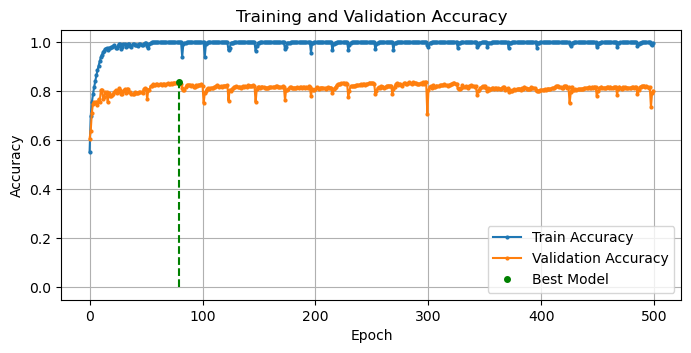

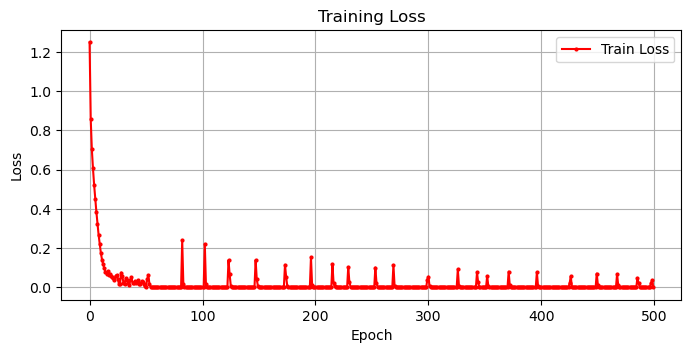

In [23]:
import matplotlib.pyplot as plt

def plotgraphs(train_acc_hist, val_acc_hist, loss_hist, best):
    # Plot training and validation accuracy
    plt.figure(figsize=(8, 3.5))
    plt.plot(train_acc_hist, label='Train Accuracy', marker='o', markersize=2)
    plt.plot(val_acc_hist, label='Validation Accuracy', marker='o', markersize=2)
    plt.plot(best, val_acc_hist[best], 'go', label='Best Model', markersize=4)
    plt.plot([best, best], [0, val_acc_hist[best]], 'g--')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot training loss
    plt.figure(figsize=(8, 3.5))
    plt.plot(loss_hist, label='Train Loss', marker='o', color='red', markersize=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.grid()
    plt.show()

ckpt = torch.load('./run1/cifar10last.pt', map_location=config.device)
train_acc_hist = ckpt['train_acc_hist']
val_acc_hist = ckpt['val_acc_hist']
loss_hist = ckpt['loss_hist']
best = np.argmax(val_acc_hist)
print(f'Best val accuracy: {100*val_acc_hist[best]:.2f}%\n')
plotgraphs(train_acc_hist, val_acc_hist, loss_hist, best)

Some important observations:
1. **Near perfect training accuracy & significant gap b/w training and validation accuracy**: Indicates overfitting.
2. **Spikes in the loss curve**: May have reduce the learning rate.
3. **Generalization (val accuracy) did not improve**: As a result of overfitting, best model was saved at around 80th epoch even if we trained the model for 500 epochs.

## 8. Regularize
Now that we fit the training dataset well, it is time to regularize the model, giving up some training accuracy and increasing the validation accuracy. We can do this using:
1. Weight decay (L2 regularization)
2. Data augmentation
3. Getting more data

## Tuning Hyperparameters:
In order to find the regularization strength (and other hyperparams) that work best, we follow a **coarse to fine strategy**.


**Coarse Search:** First find roughly good params by using a fixed step on the log scale. (like grid search)



In [24]:
config = TrainConfig(
    epochs = 90, # best model was trained to 80
    print_every = 0,
    scheduler = None,
    resume = True,
    save_ckpt = False,
    resume_lr = False,
    best_model_path = None,
    resume_path = './run1/cifar10best.pt',
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
)

results = {}
learning_rates = [3e-4, 1e-4, 3e-5]
regularization_strengths = [1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
grid = [(lr, reg) for lr in learning_rates for reg in regularization_strengths]

for i, (lr, reg) in enumerate(grid):
    model = ConvNet()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)
    acc = train_model(model, loader_train, loader_val, optimizer, config)
    results[(lr, reg)] = acc

In [24]:
# print top 10 hyperparams
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
for (lr, reg), acc in sorted_results[:10]:
    print(f"lr: {lr}, reg: {reg}, acc: {acc}")

**Fine Search:** Then use **random sampling** in a smaller region to get better values. The smaller region is decided based on the results of coarse search. Figure 1 in [this paper](https://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf) by Bergstra and Bengio shows how random search is often better than grid search.

In [25]:
# random search based on previous results
learning_rates = np.random.uniform(2.5e-5, 3e-4, 5) 
regularization_strengths = np.random.uniform(1e-5, 5e-4, 6)
grid = [(lr, reg) for lr in learning_rates for reg in regularization_strengths]

for i, (lr, reg) in enumerate(grid):
    model = ConvNet()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)
    acc = train_model(model, loader_train, loader_val, optimizer, config)
    results[(lr, reg)] = acc

Finally, we train using the best hyperparameters from the previous step. In this run we use:

1. **Data augmentation:** Works as a regularization strategy and helps increase validation accuracy.
2. **Weight decay:** Also known as L2 regularization, to reduce overfitting and improve validation accuracy.
3. **Learning rate scheduling:** For every 100 epochs that validation accuracy stops improving, we reduce learning rate by half. (The number of epochs to wait depends on the size of your dataset, of course)

In [22]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

config = TrainConfig(
    lr = 1e-4,
    reg = 2.53e-4,
    epochs = 1300,
    print_every = 0,
    scheduler = None,
    resume = True,
    save_ckpt = True,
    best_model_path = './run2/cifar10best.pt',
    last_model_path = './run2/cifar10last.pt',
    resume_path = './run1/cifar10best.pt',
    resume_lr = False,
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
)

model = ConvNet()
optimizer = optim.Adam(model.parameters(), lr=config.lr, weight_decay=config.reg)
config.scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5,
                              patience=100, cooldown=100, min_lr=1e-7, verbose=True)
val_acc = train_model(model, loader_train, loader_val, optimizer, config)

## 9. Evaluate test set performance

While we had previously achieved a validation accuracy of 83.90%, we are now able to increase it to 89.80% with the help of regularization and data augmentation. That is a significant improvement.

We also achieved a test set performance of around 87% which is quite impressive for a small sized neural network.

In [26]:
ckpt = torch.load('./run2/cifar10best.pt', map_location=config.device)
model = ConvNet()
model.load_state_dict(ckpt['model'])
model.to(config.device)
test_acc = check_accuracy(loader_test, model)
print(f'Testing accuracy: {100*test_acc:.2f}%\n')

Testing accuracy: 86.95%



Best val accuracy: 89.80%



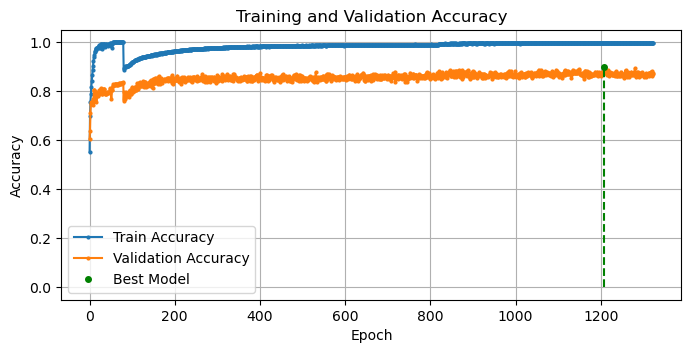

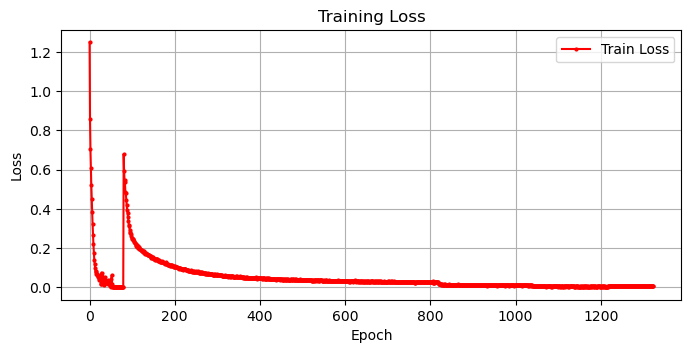

In [27]:
ckpt = torch.load('./run2/cifar10last.pt', map_location=config.device)
train_acc_hist = ckpt['train_acc_hist']
val_acc_hist = ckpt['val_acc_hist']
loss_hist = ckpt['loss_hist']
best = np.argmax(val_acc_hist)
print(f'Best val accuracy: {100*val_acc_hist[best]:.2f}%\n')
plotgraphs(train_acc_hist, val_acc_hist, loss_hist, best)

Note: If you observe the graphs you see that the loss has gone up at 80th epoch. This is because we introduced L2 regularization from that point onwards.


# Summary and Conclusion
Following the procedure described here will help you avoid a lot of potential bugs. Remember these:
1. **Simplify:** Build one small functionality at a time and verify that its working as intended before integrating. Don't do everything at once.
2. **Visualize batch data:** Visualize exactly what goes into your model, helps identify bugs related to preprocessing and augmentation.
3. **Batchnorm:** Use it, greatly helps in convergence and issues related to weight initialization.
4. **Overfit test:** Verify that you can overfit a small batch of data, else recheck your model and training pipeline.
5. **Learning rate and decay:** First start with defaults or pick a small enough learning rate and verify decreasing training loss. Train for a long time before using decay.
6. **Visualize training dynamics:** If you see near perfect training accuracy and a large gap to validation accuracy, it implies overfitting and you should try regularizing the model, either by weight decay or by getting more data or by data augmentation. If you see that both training and validation accuracy are less, its worth trying a more powerful model.
7. **Use existing models:** In general, whan you want to solve a problem, consider using the best open source models (like YOLOv7 if you're doing detection) and tweaking their repo to suit your problem.

If you've reached this point, you have a rough idea on how to structure and work on a deeplearning project. The only way to gain a solid understanding and experience is to implement projects and papers by yourself. All the best!